In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt

from datasets import load_zhang_et_al_biorxiv
from utils import round_down_sigfig
from plotting import (validation_plot, 
                      COLOR_ALPHAFOLD_ROSETTAFOLD,
                      COLOR_LIT,
                      COLOR_PRS,
                      COLOR_RRS)

In [2]:
df = pd.read_csv('../data/processed/Y2H_v1_pairwise_test_AlphaFoldRoseTTAFold_human_filtered.tsv',
                 sep='\t')

In [3]:
df['category'].value_counts()

Zhang_et_al    3222
RRS_UniProt     231
Lit-BM-24       222
hsRRS-v2         78
hsPRS-v2         60
Name: category, dtype: int64

In [4]:
df.loc[df['result'].notnull(), 'category'].value_counts()

Zhang_et_al    2676
RRS_UniProt     178
Lit-BM-24       173
hsRRS-v2         78
hsPRS-v2         58
Name: category, dtype: int64

In [5]:
zhang = load_zhang_et_al_biorxiv()
zhang['index'] = zhang['pair_id']
zhang = zhang.set_index('index')

zhang_published = pd.read_excel('../data/external/science.adt1630_data_s1_to_s8.xlsx', 
                    sheet_name='Data S3', skiprows=15)
if not (zhang_published['Protein1'] < zhang_published['Protein2']).all():
    raise UserWarning('expected sorted')
zhang_published['pair'] = zhang_published['Protein1'] + '_' + zhang_published['Protein2']
# Taking the intersection of the biorxiv pairs, which were tested in Y2H,
# and the published pairs
zhang = zhang.loc[zhang.index.isin(zhang_published['pair'].values), :]

# "Source: indicate the pair is predicted based on which pipeline among those shown in Fig. 3A. 
# D: de novo screening among protein pairs that share subcellular locality; 
# U: de novo screening among protein pairs involving proteins without known subcellular locality; 
# S: screening among genetically associated pairs extracted from the STRING database; 
# P: screening among protein pairs from PPI databases (UniProt, BioGrid, and STRING physical interactions)"
zhang['source'] = zhang.index.map(zhang_published.set_index('pair')['Source'])
if zhang['source'].isnull().any():
    raise UserWarning('missing source info')

zhang['strategy_1'] = zhang['strategy_1'] & zhang['source'].str.contains('D')
zhang['strategy_2'] = zhang['strategy_2'] & zhang['source'].str.contains('U')
zhang['strategy_3'] = zhang['strategy_3'] & zhang['source'].str.contains('S')
zhang['strategy_4'] = zhang['strategy_4'] & zhang['source'].str.contains('P')
zhang['strategy_5'] = zhang['strategy_5'] & zhang['source'].str.contains('D')
zhang['strategy_6'] = zhang['strategy_6'] & zhang['source'].str.contains('U')
zhang['strategy_7'] = zhang['strategy_7'] & zhang['source'].str.contains('S')
zhang['strategy_8'] = zhang['strategy_8'] & zhang['source'].str.contains('P')
zhang['strategy_9'] = zhang['strategy_9'] & zhang['source'].str.contains('P')

score_type = {
    'strategy_1': 'RFprob',
    'strategy_2': 'RFprob',
    'strategy_3': 'RFprob',
    'strategy_4': 'RFprob',
    'strategy_5': 'AFprob',
    'strategy_6': 'AFprob',
    'strategy_7': 'AFprob',
    'strategy_8': 'AFprob',
    'strategy_9': 'AFprob',
 }

strategy_description = {
    'strategy_1': 'screen:CCcom->DCA->RF2-ppi',
    'strategy_2': 'screen:CCunk->DCA->RF2-ppi',
    'strategy_3': 'GI->RF2-ppi',
    'strategy_4': 'PPI_DB->RF2-ppi',
    'strategy_5': 'screen:CCcom->DCA->RF2-ppi->AF2',
    'strategy_6': 'screen:CCunk->DCA->RF2-ppi->AF2',
    'strategy_7': 'GI->RF2-ppi->AF2',
    'strategy_8': 'PPI_DB->RF2ppi->AF2',
    'strategy_9': 'PPI_DB->AF2',
 }


uniprot_to_orf_id = pd.read_csv('../data/internal/uniprot_ac_to_orf_id_used_for_Zhang_et_al_experiment.tsv',
                                sep='\t')
zhang_mapped = (pd.merge(zhang, 
          uniprot_to_orf_id,
          how='left',
          left_on='#Protein1',
          right_on='uniprot_ac')
.rename(columns={'uniprot_ac': 'uniprot_ac_1',
                 'orf_id': 'orf_id_1'})
)
zhang_mapped = (pd.merge(zhang_mapped, 
          uniprot_to_orf_id,
          how='left',
          left_on='Protein2',
          right_on='uniprot_ac')
.rename(columns={'uniprot_ac': 'uniprot_ac_2',
                 'orf_id': 'orf_id_2'})
)
zhang_mapped = zhang_mapped.dropna(subset=['orf_id_1', 'orf_id_2'])
zhang_mapped['orf_id_1'] = zhang_mapped['orf_id_1'].astype(int)
zhang_mapped['orf_id_2'] = zhang_mapped['orf_id_2'].astype(int)
zhang_mapped['orf_id_pair'] = (zhang_mapped[['orf_id_1', 'orf_id_2']].min(axis=1).astype(str)
                 + '_' +
                 zhang_mapped[['orf_id_1', 'orf_id_2']].max(axis=1).astype(str))

df = pd.merge(df, zhang_mapped, how='left', on='orf_id_pair')
if df.index.duplicated().any():
    raise UserWarning('unexpected duplicates')
df = df.drop_duplicates(subset=['category', 'orf_id_pair'])

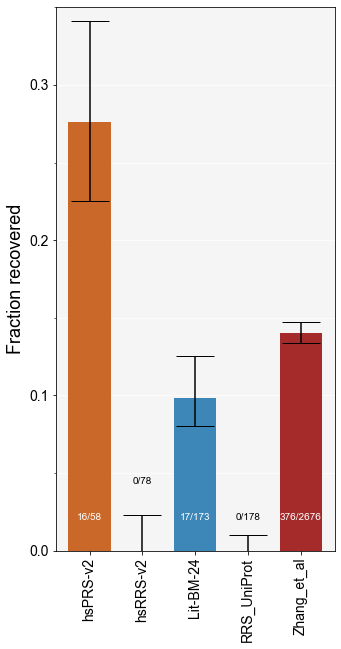

In [6]:
cats = [
        'hsPRS-v2',
       'hsRRS-v2', 
       'Lit-BM-24', 
        'RRS_UniProt', 
        'Zhang_et_al', 
       ]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=5, h=10)
validation_plot(data=df,
                selections=[df['category'] == c for c in cats],
                labels=cats,
                y_max=0.35,
                colors=[COLOR_PRS, COLOR_RRS, COLOR_LIT, COLOR_RRS] + [COLOR_ALPHAFOLD_ROSETTAFOLD] ,
                xlabel_rotation=90
                )
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), fontsize=14);
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), fontsize=14);
ax.set_ylabel('Fraction recovered', fontsize=18)
fig.savefig('../figures/published_overlap_subset_Zhang-et-al_Y2H.pdf',
            bbox_inches='tight')

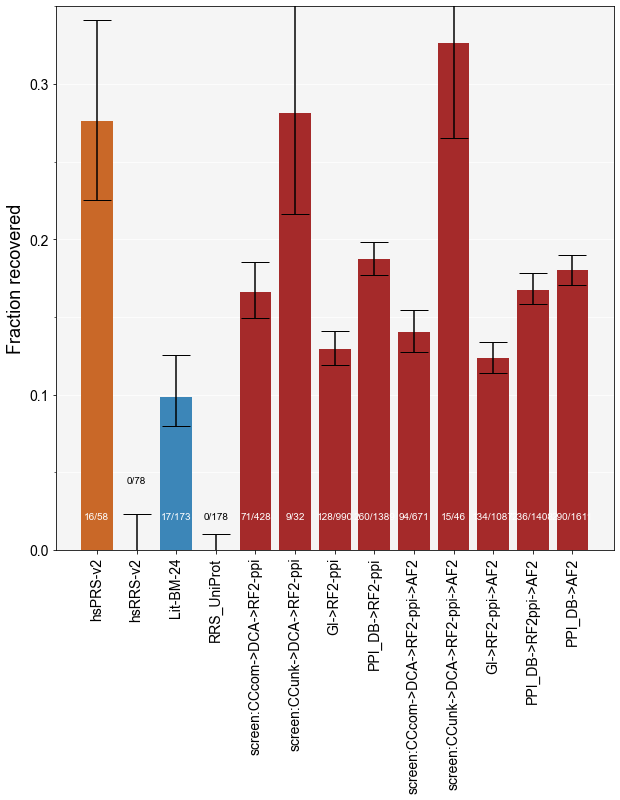

In [7]:
ctrl_cats = [
        'hsPRS-v2',
       'hsRRS-v2', 
       'Lit-BM-24', 
        'RRS_UniProt', 
       ]

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=10, h=10)
rows = ([df['category'] == c for c in ctrl_cats] + 
[(df['category'] == 'Zhang_et_al') & 
 (df[f'strategy_{i}'] == True) for i in range(1, 10)]


)
validation_plot(data=df,
                selections=rows,
                labels=ctrl_cats + [f'strategy_{i}' for i in range(1, 10)],
                colors=[COLOR_PRS, COLOR_RRS, COLOR_LIT, COLOR_RRS] + [COLOR_ALPHAFOLD_ROSETTAFOLD] * (len(rows) - len(ctrl_cats)),
                y_max=0.35,
                xlabel_rotation=90)
ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), fontsize=14);
ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), fontsize=14);
ax.set_ylabel('Fraction recovered', fontsize=18)
ax.set_xticklabels([strategy_description.get(xt.get_text(), xt.get_text()) for xt in ax.get_xticklabels()])
fig.savefig('../figures/published_overlap_subset_Zhang-et-al_Y2H-by-strategy.pdf',
            bbox_inches='tight')

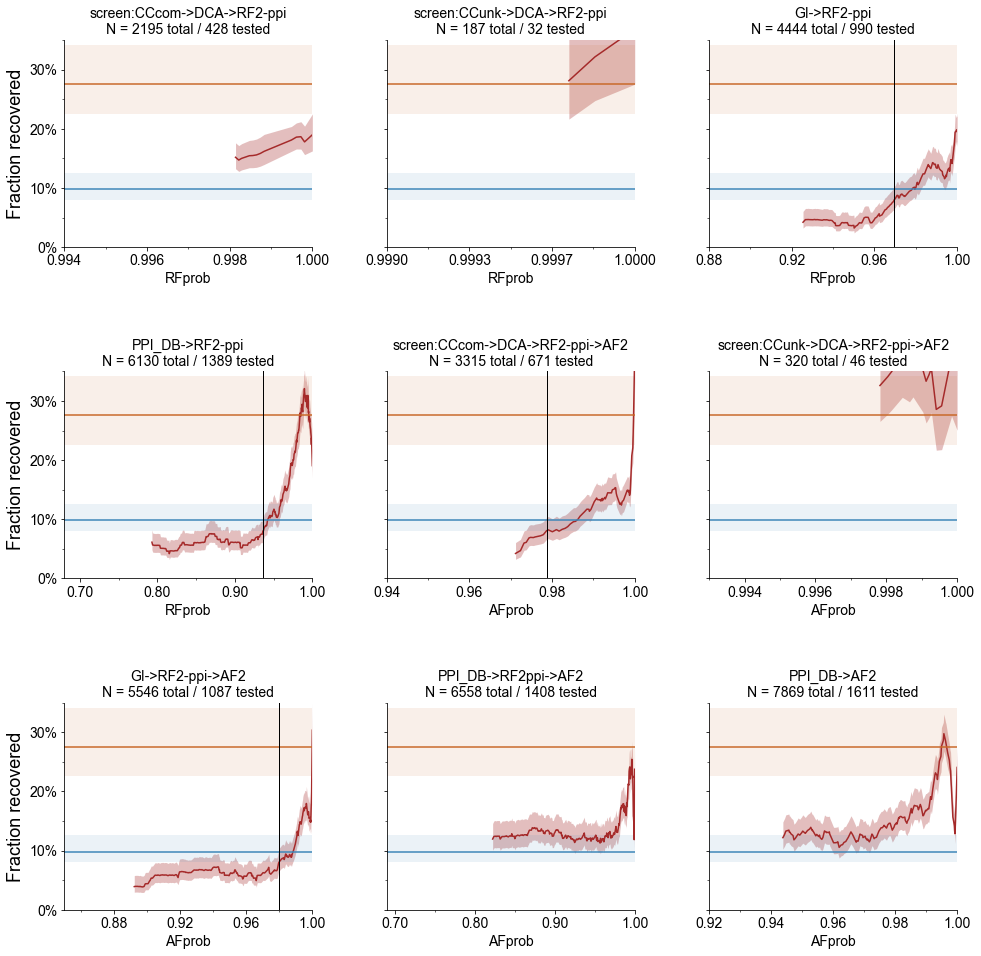

In [8]:
def y2h_sliding_window_plot(
    data,
    selections,
    window_size=250,
    threshold=None,
    xmin=None,
    xmax=None,
    ymax=None,
    score_column="score",
    labels=None,
    colors=None,
    line_styles=None,
    ax=None,
    threshold_label=None,
    threshold_color="grey",
    draw_controls=True,
):
    """ """
    if ax is None:
        ax = plt.gca()
    if labels is None:
        labels = [""] * len(selections)
    if colors is None:
        colors = [None] * len(selections)
    if line_styles is None:
        line_styles = ["-"] * len(selections)
    if xmin is None:
        xmin = data.loc[selections[0], score_column].min()
    if xmax is None:
        xmax = data[score_column].max()
    for selection, label, color, line_style in zip(
        selections, labels, colors, line_styles
    ):
        unique_vals = data.loc[selection, score_column].sort_values().drop_duplicates().values
        sorted_df = (data.loc[selection, :]
                    .sort_values(score_column)
                    .copy()
                    .reset_index())
        bounds = []
        for lower_val in unique_vals:
            lower_val_idx = sorted_df.loc[sorted_df[score_column] == lower_val, :].index[0]
            upper_val_idx = lower_val_idx + (window_size - 1)
            if upper_val_idx > sorted_df.index[-1]:
                upper_val_idx = sorted_df.index[-1]
            upper_val = sorted_df.loc[upper_val_idx, score_column]
            bounds.append((lower_val, upper_val))
        ns = np.array([data.loc[selection & (data[score_column] >= low) 
                                & (data[score_column] <= high), 'result'].notnull().sum() for low, high in bounds])
        pos = np.array([(data.loc[selection & (data[score_column] >= low) 
                                  & (data[score_column] <= high), 'result'] == True).sum() for low, high in bounds])
        points = np.array([data.loc[selection & (data[score_column] >= low) 
                                    & (data[score_column] <= high) & data['result'].notnull(), score_column].mean() for low, high in bounds])
        neg = ns - pos
        fracs = pos / ns
        ax.plot(
            points, fracs, color=color, label=label, linestyle=line_style
        )
        intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
        errs = [fracs - intv[0], intv[1] - fracs]
        errs[0][pos == 0] = 0.0
        errs[1][neg == 0] = 0.0
        ax.fill_between(
            points,
            fracs - errs[0],
            fracs + errs[1],
            color=color,
            alpha=0.3,
            linewidth=0,
        )
        cutoff = bounds[0][0]
        line_below_pos_ctrl = True
        ctrl_cat = 'Lit-BM-24'
        c = (data.loc[(data['category'] == ctrl_cat), 'result'] == True).sum()
        d = (data.loc[(data['category'] == ctrl_cat), 'result'] == False).sum()
        ctrl_lower_bound = stats.beta.interval(0.6827, c + 1, d + 1)[0]
        for a, b, mean_score_value in zip(pos, neg, points):
            f = a / (a + b)
            if f >= ctrl_lower_bound:
                cutoff = mean_score_value
                break
            """
            _or, pval = stats.fisher_exact([[a, b], [c, d]], alternative='less')
            if pval < 0.05:
                line_below_pos_ctrl = True
            elif line_below_pos_ctrl and pval >= 0.05:
                cutoff = mean_score_value
                line_below_pos_ctrl = False
            """
        if cutoff == points[0]:
            cutoff = None
    ax.set_ylim(0, ymax)
    ax.set_xlim(xmin, xmax)
    ax.set_ylabel("Fraction positive")
    ax.set_xlabel("Score threshold")
    #ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)

    if draw_controls:
        for ctrl_cat, ctrl_color in [('hsPRS-v2', COLOR_PRS), ('Lit-BM-24', COLOR_LIT)]:
            pos = (data.loc[(data['category'] == ctrl_cat), 'result'] == True).sum()
            neg = (data.loc[(data['category'] == ctrl_cat), 'result'] == False).sum()
            frac = pos / (pos + neg)
            intv = stats.beta.interval(0.6827, pos + 1, neg + 1)
            ax.axhline(y=frac, color=ctrl_color)
            ax.fill_between(
                [xmin, xmax],
                [intv[0], intv[0]],
                [intv[1], intv[1]],
                color=ctrl_color,
                alpha=0.1,
                linewidth=0,
            )

    if threshold is not None:
        ax.axvline(
            x=threshold,
            ymin=0,
            ymax=1,
            linestyle="--",
            color=threshold_color,
            linewidth=1,
        )
        if threshold_label is not None:
            ax.text(
                x=threshold + (xmax - xmin) * 0.02,
                y=ymax,
                s=threshold_label,
                color=threshold_color,
                verticalalignment="top",
                horizontalalignment="left",
                fontsize=8,
            )
    return cutoff


fig, axs = plt.subplots(nrows=3, ncols=3)
fig.set_size_inches(w=16, h=16)
ctrl_cats = [
        'hsPRS-v2',
       'hsRRS-v2', 
       'Lit-BM-24', 
        'RRS_UniProt', 
       ]


cutoffs = {}
for i, ax in enumerate(axs.flatten()):
    strategy = f'strategy_{i+1}'
    score = score_type[strategy]
    xmin = zhang.loc[zhang[strategy], score].min()
    xmin = round_down_sigfig(xmin, 3 if i in [0, 1, 5] else 2)
    cutoffs[strategy] = y2h_sliding_window_plot(
        data=df,
        selections=[(df['category'] == 'Zhang_et_al') & (df[strategy] == True)],
        score_column=score,
        window_size=250,
        colors=[COLOR_ALPHAFOLD_ROSETTAFOLD],
        ymax=0.35,
        xmin=xmin,
        xmax=1.,
        ax=ax
        )
    #ax.yaxis.set_ticklabels([y.get_text() for y in ax.yaxis.get_ticklabels()])#, fontsize=14);
    ax.set_ylabel('Fraction recovered', fontsize=18)
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], minor=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    """
    if i == 1:
        ax.xaxis.set_ticklabels(['{:.4f}'.format(x) for x in ax.get_xticks()], fontsize=14)        
    elif i in [0, 5]:
        ax.xaxis.set_ticklabels(['{:.3f}'.format(x) for x in ax.get_xticks()], fontsize=14)        
    else:
        ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)
    """
    ax.set_xlabel(score, fontsize=14)
    ax.set_title(strategy_description[strategy] + 
                 f"\nN = {zhang[strategy].sum()} total / {df.loc[(df['category'] == 'Zhang_et_al') & df[strategy], 'result'].notnull().sum()} tested",
                 fontsize=14)
    if cutoffs[strategy] is not None:
        ax.axvline(x=cutoffs[strategy], color='black', linewidth=1)
for ax in axs[:, 0]:
    ax.yaxis.set_ticklabels([f'{y:.0%}' for y in ax.get_yticks()], fontsize=14);
for ax in axs[:, 1:].flatten():
    ax.set_yticklabels([])
    ax.set_ylabel('')

ax = axs.flatten()[0]
axs.flatten()[0].set_xticks(np.linspace(0.994, 1, 4))
axs.flatten()[0].set_xticks(np.linspace(0.994, 1, 7), minor=True)
axs.flatten()[0].xaxis.set_ticklabels(['{:.3f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[1]
ax.set_xticks(np.linspace(0.9990, 1, 4))
ax.set_xticks(np.linspace(0.9990, 1, 7), minor=True)
ax.xaxis.set_ticklabels(['{:.4f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[2]
ax.set_xticks(np.linspace(0.88, 1, 4))
ax.set_xticks(np.linspace(0.88, 1, 7), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[3]
ax.set_xticks(np.linspace(0.70, 1, 4))
ax.set_xticks(np.linspace(0.70, 1, 7), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[4]
ax.set_xticks(np.linspace(0.94, 1, 4))
ax.set_xticks(np.linspace(0.94, 1, 7), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[5]
ax.set_xticks(np.linspace(0.994, 1, 4))
ax.set_xticks(np.linspace(0.993, 1, 8), minor=True)
ax.xaxis.set_ticklabels(['{:.3f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[6]
ax.set_xticks(np.linspace(0.88, 1, 4))
ax.set_xticks(np.linspace(0.86, 1, 8), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[7]
ax.set_xticks(np.linspace(0.7, 1, 4))
ax.set_xticks(np.linspace(0.7, 1, 7), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        

ax = axs.flatten()[8]
ax.set_xticks(np.linspace(0.92, 1, 5))
ax.set_xticks(np.linspace(0.92, 1, 9), minor=True)
ax.xaxis.set_ticklabels(['{:.2f}'.format(x) for x in ax.get_xticks()], fontsize=14)        


plt.subplots_adjust(wspace=0.3, hspace=0.6)
fig.savefig('../figures/published_overlap_subset_Zhang-et-al_Y2H-by-strategy-sliding-window-by-score.pdf',
            bbox_inches='tight')

0.9400000000000001
0.85
0.6900000000000001


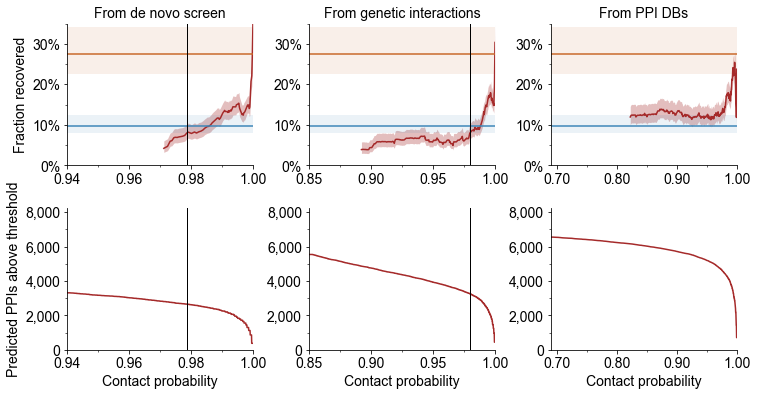

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=False)
fig.set_size_inches(w=4*3, h=3*2)


for i, ax_col in zip([5, 7, 8], axs.T):
    strategy = f'strategy_{i}'
    score = 'AFprob'
    ax = ax_col[0]
    xmin = zhang.loc[zhang[strategy], score].min()
    xmin = round_down_sigfig(xmin, 2)
    y2h_sliding_window_plot(
        data=df,
        selections=[(df['category'] == 'Zhang_et_al') & (df[strategy] == True)],
        score_column=score,
        window_size=250,
        colors=[COLOR_ALPHAFOLD_ROSETTAFOLD],
        ymax=0.35,
        xmin=xmin,
        xmax=1.,
        ax=ax,
        #draw_controls=(i==8),
        )
    ax.set_yticks([0, 0.1, 0.2, 0.3])
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], minor=True)
    #ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), fontsize=14);
    ax.set_ylabel('Fraction recovered', fontsize=14)
    #ax.xaxis.set_ticklabels(ax.get_xticklabels(), fontsize=14)
    #ax.set_title(strategy_description[strategy] + 
    #             f"\nN = {zhang[strategy].sum()} total / {df.loc[(df['category'] == 'Zhang_et_al') & df[strategy], 'result'].notnull().sum()} tested",
    #             fontsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticklabels([f'{y:.0%}' for y in ax.get_yticks()], fontsize=14);
    ax.set_xlabel('')
    ax.set_xlim(xmin, 1)

    print(xmin)
    if cutoffs[strategy] is not None:
        ax.axvline(x=cutoffs[strategy], color='black', linewidth=1)

    ax = ax_col[1]
    points = np.linspace(xmin, 1, 1000)
    ax.plot(points,
          [(zhang.loc[zhang[strategy], score] >= x).sum() for x in points],
          '-',
            color=COLOR_ALPHAFOLD_ROSETTAFOLD,
            clip_on=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Predicted PPIs above threshold', fontsize=14)
    ax.set_ylim(0, 8250)
    ax.set_yticks(range(0, 8001, 2000))
    ax.set_yticks(range(0, 8001, 1000), minor=True)
    ax.set_xlim(xmin, 1)
    ax.set_xlabel('Contact probability', fontsize=14)
    ax.yaxis.set_ticklabels([f'{int(y):,}' for y in ax.get_yticks()], fontsize=14)
    if cutoffs[strategy] is not None:
        ax.axvline(x=cutoffs[strategy], color='black', linewidth=1)


for ax in axs[:, 1:].flatten():
    ax.set_ylabel('')
for ax in axs[0, :].flatten():
    ax.set_xticklabels([])

axs[0, 0].set_title('From de novo screen', fontsize=14)
axs[0, 1].set_title('From genetic interactions', fontsize=14)
axs[0, 2].set_title('From PPI DBs', fontsize=14)

for i in range(2):
    axs[i, 0].set_xticks(np.linspace(0.94, 1, 4))
    axs[i, 0].set_xticks([0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1], minor=True)
    axs[i, 1].set_xticks([0.85, 0.9, 0.95, 1])
    axs[i, 1].set_xticks([0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1], minor=True)
    axs[i, 2].set_xticks([0.70, 0.80, 0.9, 1])
    axs[i, 2].set_xticks([0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1], minor=True)
for ax in axs.flatten():
    ax.xaxis.set_ticklabels([f'{x:.2f}' for x in ax.get_xticks()], fontsize=14)



plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.savefig('../figures/published_overlap_subset_Zhang-et-al_Y2H-by-strategy-sliding-window-by-score_subset.pdf',
            bbox_inches='tight')

In [10]:
# setting PDB-DB cutoffs to 0 since this was changed between
# the preprint and published version
cutoffs['strategy_4'] = None
cutoffs['strategy_8'] = None
cutoffs['strategy_9'] = None

if zhang_published['pair'].duplicated().any():
    raise UserWarning('unexpected duplicates')
zhang_published = zhang_published.set_index('pair')

for strategy, cutoff in cutoffs.items():
    if cutoff is  None:
        zhang['core_' + strategy] = zhang[strategy]
    else:
        zhang['core_' + strategy] = zhang[strategy] & (zhang[score_type[strategy]] >= cutoff)

zhang['core'] = (
    zhang['core_strategy_1']
    | zhang['core_strategy_2']
    | zhang['core_strategy_3']
    | zhang['core_strategy_4']
    | zhang['core_strategy_5'] 
    | zhang['core_strategy_6']
    | zhang['core_strategy_7']
    | zhang['core_strategy_8']
    | zhang['core_strategy_9']
)
zhang_core = zhang.loc[zhang['core'], :].copy()
print(f'{zhang_core.shape[0]} of {zhang.shape[0]} PPIs left after filtering')
removed_pairs = set(zhang.index).difference(set(zhang_core.index))
zhang_core = zhang_published.loc[~zhang_published.index.isin(removed_pairs), :].copy()
zhang_core.to_csv('../output/AFRF-core_human.tsv', sep='\t')

11817 of 13867 PPIs left after filtering
